In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import imageio
%matplotlib inline

In [2]:
from comet_ml import Experiment
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-epilepsy-segmentation", workspace="kondratevakate")

from tqdm import tqdm_notebook, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

import pandas as pd

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-epilepsy-segmentation/89989bf501ed48d8807336abbe83ca2f



In [3]:
!nvidia-smi

Thu Jun  4 16:56:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 21%   21C    P8     9W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts, plot_predicted
from utils.data import MriSegmentation

  0%|          | 0/15 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 15/15 [00:01<00:00, 11.43it/s]


Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


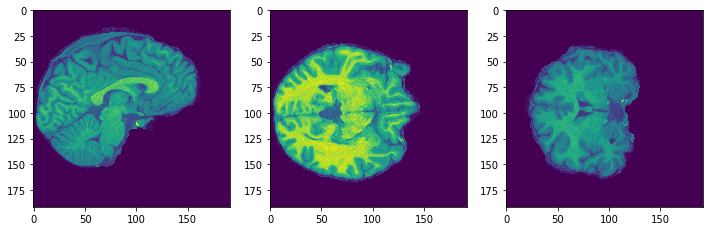

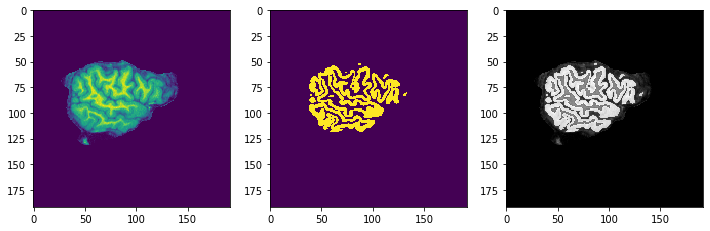

In [5]:
data_params = {
    'sample':'pirogov', 
    'prefix':'fcd',
    'mask':'seg', 
    'ignore_missing':'True',
#     'coord_min':(30, 30, 30),
#     'img_shape' :(192, 192, 192)
}

fcd_data = MriSegmentation(**data_params)

print("Dataset size: {}".format(len(fcd_data)))
print("Labels distribution: {}\n".format(np.unique(fcd_data.target, return_counts=True)))
img, mask = fcd_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(mask.shape))
plot_central_cuts(img)
plot_predicted(img, mask, delta = -50, title="")

## 1. Segmentation: Validation of baseline model

In [8]:
from routine import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [9]:
from torchio.transforms import HistogramStandardization

histogram_landmarks_path = 'weights/fcd_train_data_landmarks.npy'
landmarks = np.load(histogram_landmarks_path)

transform = Compose([
    HistogramStandardization(landmarks_dict={MRI: landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad(192, 192, 192),
])

validation_dataset = get_torchio_dataset(fcd_data.img_files, fcd_data.img_seg, transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1)

In [10]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer=8)
model.load_state_dict(torch.load('weights/whole_im_train_seg_parc_epoch_7.pth'))

<All keys matched successfully>

In [11]:
dsc, asd_mean, asd_std, iou = validate_dsc_asd(model, validation_loader)
print('mean dsc', np.mean(dsc),'mean asd', np.mean(asd_mean), 'mean iou', np.mean(iou))

100%|██████████| 15/15 [01:53<00:00,  7.54s/it]

mean dsc 0.9399542899146459 mean asd 0.11382715191871143 mean iou 0.8874126115531707


In [13]:
from metrics import (compute_dice_coefficient, compute_surface_distances, 
                     compute_average_surface_distance)

def get_iou_score(prediction, ground_truth):
    intersection, union = 0, 0
    intersection += np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union += np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    iou_score = float(intersection) / union
    return iou_score

def calculate_metrics(surface, prediction):
    dsc = compute_dice_coefficient(surface, prediction)
    asd_mean, asd_std = compute_average_surface_distance(
        compute_surface_distances(
            surface, prediction, spacing_mm=(1,1,1))
    )
    
    iou = get_iou_score(prediction, ground_truth)
    
    return dsc, asd_mean, asd_std, iou

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

### 2. Lesion segmentaton on pretrained: Combined mask

In [73]:
data_params = {
    'sample':'pirogov', 
    'prefix':'fcd',
    'mask':'bb', 
    'mask_path':'/gpfs/gpfs0/sbi/data/fcd_classification_bank/masks/combined/',
    'ignore_missing':'True',
#     'coord_min':(30, 30, 30),
#     'img_shape' :(192, 192, 192)
}

fcd_data = MriSegmentation(**data_params)

print("Dataset size: {}".format(len(fcd_data)))
print("Labels distribution: {}\n".format(np.unique(fcd_data.target, return_counts=True)))

  7%|▋         | 1/15 [00:00<00:01,  8.07it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 15/15 [00:01<00:00, 10.25it/s]

Dataset size: 15
Labels distribution: (array([1]), array([15]))



Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


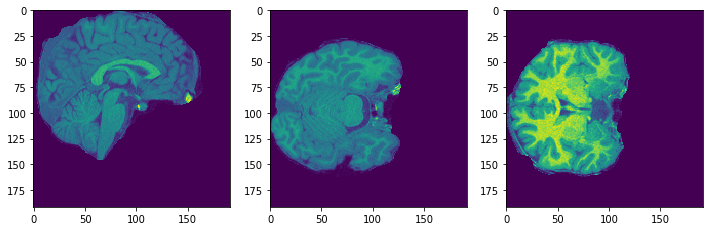

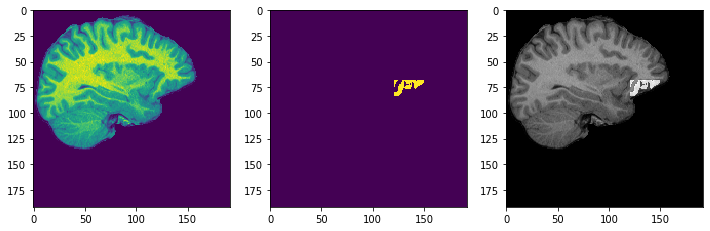

In [79]:
img, mask = fcd_data[10]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(mask.shape))
plot_central_cuts(img)
plot_predicted(img, mask, delta = 30, title="")

In [44]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_data)), y=fcd_data.target))

training_transform = Compose([
#     RescaleIntensity((0, 1)),  # so that there are no negative values for RandomMotion
#     RandomMotion(),
    HistogramStandardization(landmarks_dict={MRI: landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
    RandomFlip(axes=(0,)),
    OneOf({
        RandomAffine(): 0.8,
        RandomElasticDeformation(): 0.2,
    }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks_dict={MRI: landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
])

In [55]:
training_loader, validation_loader = get_loaders(fcd_data, cv_splits[0], training_transform = training_transform,
    validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects


In [56]:
experiment.set_name("Whole images pretrained, seg+parc, combined")

In [66]:
torch.cuda.empty_cache()

# model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer=8, patience=1)
# model.load_state_dict(torch.load('weights/whole_im_train_seg_parc_epoch_7.pth'))

training_params =  {
    'num_epochs': 10, 
    'training_loader':training_loader, 
    'validation_loader':validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'weights_stem':'whole_im_pretrain_seg_parc',
    'save_epoch': 20,
    'experiment': False,
    'verbose':True
}

train(**training_params)

  0%|          | 0/10 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [60]:
# torch.save(model.state_dict(), 'weights/weights_aseg_aparc_pretrained_10_epochs.pth')

DICE:  tensor([[0.0663]], device='cuda:0')
IOU:  0.0342739695589379


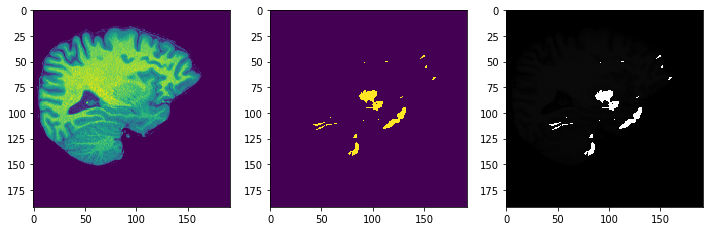

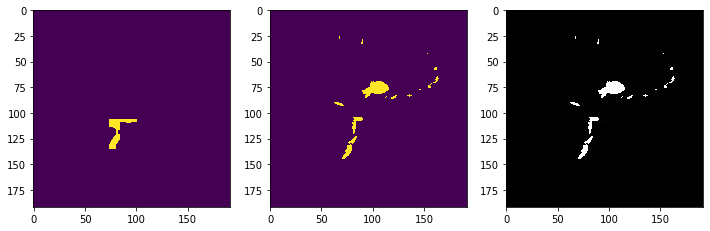

In [72]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
print('DICE: ', get_dice_score(targets, labels[0]))
print('IOU: ', get_iou_score(targets.cpu().numpy().astype(np.uint8), foreground))
plot_predicted(inputs, foreground, 30, title="An image")
plot_predicted(targets, foreground, -20, title="Segmentation")

In [59]:
dsc, asd_mean, asd_std = validate_dsc_asd(model, validation_loader)
print('mean dsc', np.mean(dsc),'mean asd', np.mean(asd_mean))

100%|██████████| 5/5 [00:20<00:00,  4.16s/it]

mean dsc 0.03310047952631858 mean asd 5.90179060364787


In [ ]:
if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))

In [ ]:
def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets[0][0][(np.isin(targets[0][0], LIST_FCD))] = 1
    targets[targets >= 1000] = 1
    targets[targets != 1] = 0
    targets = targets.to(device)    
    return inputs, targets

In [21]:
model.load_state_dict(torch.load('weights/whole_im_train_seg_parc_epoch_7.pth'))
dsc, asd_mean, asd_std = validate_dsc_asd(model, validation_loader)
print('mean dsc', np.mean(dsc),'mean asd', np.mean(asd_mean))

[[[[[[[[[[[[[[[[], 0.9229267590890713], 0.9475920452002522],
             0.948106343173741],
            0.9484128145827845],
           0.8701900866526744],
          0.9232782991251401],
         0.9489123909285692],
        0.944014470860155],
       0.953936974519379],
      0.9489394340785625],
     0.9497796359666059],
    0.9376504230476321],
   0.9472321729153867],
  0.9535238696773515],
 0.9548186289023853]

DICE:  tensor([[0.9229]], device='cuda:0')
IOU:  0.0


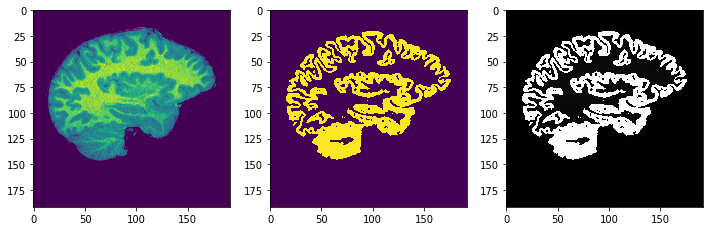

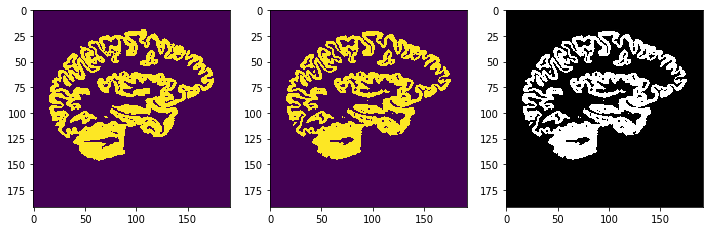

In [15]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
print('DICE: ', get_dice_score(targets, labels[0]))
print('IOU: ', get_iou_score(targets.cpu().numpy().astype(np.uint8), foreground))
plot_predicted(inputs, foreground, 30, title="An image")
plot_predicted(targets, foreground, 30, title="Segmentation")

In [ ]:
def cross_val_score(cnn_model, train_dataset, cv, device, metric, 
                    model_load_path=None, batch_size=10, val_dataset=None, transfer=False, 
                    finetune=False, experiment = False, max_epoch=20):
    
    assert not (transfer and finetune)
    assert (transfer == False) or (transfer == True and model_load_path is not None)

    use_rest = True
    if val_dataset is None:  # smri case or fmri case without rest
        val_dataset = train_dataset
        use_rest = False

    cv_splits = list(cv.split(X=np.arange(len(train_dataset)), y=train_dataset.target))
    val_metrics = []

    for i in range(len(cv_splits)):
        train_idx, val_idx = cv_splits[i]

        # train data
        if model_load_path is None or transfer or finetune:
            train_idx = stratified_batch_indices(train_idx, train_dataset.target[train_idx])
            train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

        # val data
        if use_rest:
            val_mask = (np.isin(val_dataset.pids, train_dataset.pids[train_idx]) == False)
            val_idx = np.arange(len(val_dataset))[val_mask]
            del val_mask
        
        val_loader = DataLoader(Subset(val_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

        eps = 1e-2 if use_rest else 3e-3
        model, optimizer, scheduler = create_model_opt(cnn_model)
        
        _, _, _, last_val_metric = train(model, optimizer, scheduler,
                                         train_loader, val_loader, device,
                                        metric=metric, 
                                        verbose=1,  
                                        max_epoch=max_epoch,
                                        eps=eps,
                                        experiment=experiment)
        
        val_metrics.append(last_val_metric)
                
        if model_load_path:  # no train, just validation
            model, optimizer = create_model_opt(model_load_path, transfer=False)
            criterion = nn.CrossEntropyLoss()
            with torch.no_grad():
                val_losses, val_probs, val_targets = run_one_epoch(
                    model, val_loader, criterion, False, device, scheduler)
            val_metric = metric(val_targets, val_probs)
            val_metrics.append(val_metric)
            
        del train_loader, val_loader, model, optimizer, scheduler

    return val_metrics